In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import chi2

In [2]:
df = pd.read_csv('data3a.csv')
df.head(5)

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


In [3]:
def calc_delta_d(x, y):
    """一定モデルとxモデルの逸脱度の差を求める

    Args:
        x: サイズ
        y: 種子数

    Returns:
        const_d - x_d (float): 逸脱度の差
        const_result: 一定モデルの結果
        x_result: xモデルの結果
    """
    # 一定モデルの場合
    const = np.array([1] * len(x)).reshape(-1, 1)
    const_model = sm.GLM(y, const, family=sm.families.Poisson())
    const_result = const_model.fit()
    const_d = const_result.deviance
    
    # xモデルの場合
    x = sm.add_constant(x)
    x_model = sm.GLM(y, x, family=sm.families.Poisson())
    x_result = x_model.fit()
    x_d = x_result.deviance
    
    return const_d - x_d, const_result, x_result

In [4]:
lam = np.exp(calc_delta_d(df['x'], df['y'])[1].params['const'])
print('一定モデルで推定された平均種子数: {}'.format(lam))

observed_delta_d = calc_delta_d(df['x'], df['y'])[0]
print('逸脱度の差: {}'.format(observed_delta_d))

一定モデルで推定された平均種子数: 7.830000000000001
逸脱度の差: 4.513941078851801


In [5]:
def plot_delta_d(x, lam=7.85, observed_delta_d=4.5, num_sample=1000):
    """逸脱度の差の確率分布のプロット

    Args:
        x: サイズ
        lam (float, optional): 一定モデルで推定された平均種子数. Defaults to 7.85.
        observed_delta_d (float, optional): 観察された逸脱度の差. Defaults to 4.5.
        num_sample (int, optional): サンプル数. Defaults to 1000.

    Returns:
        delta_d_list (list): 逸脱度の差のリスト
    """
    delta_d_list = []
    # pb
    for i in range(num_sample):
        np.random.seed(i)
        y = np.random.poisson(lam=lam, size=len(x))
        delta_d = calc_delta_d(x, y)[0]
        delta_d_list.append(delta_d)
        
    plt.hist(delta_d_list, bins=50)
    plt.axvline(observed_delta_d, color='black')
    
    return delta_d_list

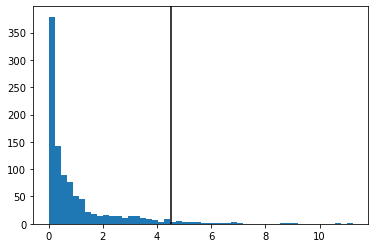

In [6]:
delta_d_list = plot_delta_d(df['x'], lam=lam, observed_delta_d=observed_delta_d)

In [7]:
pd.Series(delta_d_list).describe()

count    1000.000000
mean        0.998564
std         1.481499
min         0.000003
25%         0.099596
50%         0.406487
75%         1.166055
max        11.223541
dtype: float64

In [8]:
# P値を求める
(np.array(delta_d_list) >= observed_delta_d).sum() / len(delta_d_list)

0.039

In [9]:
# 棄却点を求める
np.percentile(np.array(delta_d_list), 95)

4.100229386145446

In [10]:
# カイ二乗分布で近似した時のP値
chi2.sf(x=observed_delta_d, df=1)

0.033619691008985805